Vehicle Detection Project

In [85]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline


# import the images
vehicle_images = glob.glob('./training_data/vehicles/*/*')
print(len(vehicle_images))

non_vehicle_images = glob.glob('./training_data/non-vehicles/*/*')
print(len(non_vehicle_images))

8792
8968


In [161]:
# collect and modify where necessary useful functions from lessons

# return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, transform_sqrt=False):
#     if visualizing the image then return the image also not just features
    if vis == True:
#         skimage hog function takes in a single color channel img and various params
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_sqrt, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_sqrt, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# compute color histogram feature vectors for different color spaces
def bin_spatial(img, color_space='RGB', size=(32, 32)):
         
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
# dont need to specify the bin range and will get messed up with pngs
def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# extract features from list of images
def extract_features(imgs, color_space='RGB', spatial_feat=True, hist_feat=True, hog_feat=True, hog_channel=0, spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        collected_features = []
        # Read in each one by one
        img = mpimg.imread(file)
#         convert to appropriate color space
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=(32, 32))
            collected_features.append(spatial_features)
        # Apply color_hist() also with a color space option now
        if hist_feat == True:
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
            collected_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                hog_features = np.ravel(hog_features)
            collected_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(collected_features))
    # Return list of feature vectors
    return features


# extract features from list of images
def extract_features_one_img(img, color_space='RGB', spatial_feat=True, hist_feat=True, hog_feat=True, hog_channel=0, spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, vis=False):
    # Create a list to append feature vectors to
    features = []
    collected_features = []
    # Iterate through the list of images
#         convert to appropriate color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=(32, 32))
        collected_features.append(spatial_features)
    # Apply color_hist() also with a color space option now
    if hist_feat == True:
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
        collected_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            hog_features = np.ravel(hog_features)
        collected_features.append(hog_features)
    # Append the new feature vector to the features list
    features.append(np.concatenate(collected_features))
    
    if vis == True:
        return features, hog_image
    else:
        # Return list of feature vectors
        return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features_one_img(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def draw_boxes(img, bboxes, color=(0, 255, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

# draw bounding boxes around places where labels created from heatmap indicate positive
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,255), 6)
    # Return the image
    return img

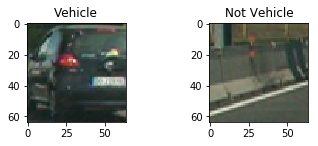

In [87]:
# get random car and not car images

vehicle_idx = np.random.randint(0, len(vehicle_images))
vehicle_img = mpimg.imread(vehicle_images[vehicle_idx])
non_vehicle_idx = np.random.randint(0, len(non_vehicle_images))
non_vehicle_img = mpimg.imread(non_vehicle_images[non_vehicle_idx])

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.set_title("Vehicle")
ax1.imshow(vehicle_img)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title("Not Vehicle")
ax2.imshow(non_vehicle_img)


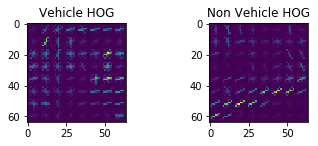

In [88]:
# define paramaters for feature extraction
# experimented with different color spaces but had the best results with yuv, yuv also mimics how people see
color_space = 'YUV'
spatial_feat = True
hist_feat = True
hog_feat = True
# shows improvement up to 9 then tapers off
orient = 9
pix_per_cell = 8
# had best accuracy with 2
cell_per_block = 2
hog_channel = 0
# increasing to 32 from 16 improved accuracy, increasing to 64 increased feature vector length but make accur
spatial_size = (32,32)
hist_bins = 32

vehicle_features, vehicle_hog_img = extract_features_one_img(vehicle_img, color_space=color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, hist_bins=hist_bins, orient=orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, vis=True)
non_vehicle_features, non_vehicle_hog_img = extract_features_one_img(non_vehicle_img, color_space=color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, hist_bins=hist_bins, orient=orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, vis=True)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.set_title("Vehicle HOG")
ax1.imshow(vehicle_hog_img)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title("Non Vehicle HOG")
ax2.imshow(non_vehicle_hog_img)

# change hog_channel for processing other images because although takes longer to train increases accuracy significantly
hog_channel = 'ALL'

In [89]:
# try to train dataset

t = time.time()
# restrict the number samples so trains faster
n_samples = 1000
# random_idxs = np.random.randint(0, len(vehicle_images), n_samples)
# test_vehicles = np.array(vehicle_images)[random_idxs]
# test_non_vehicles = np.array(non_vehicle_images)[random_idxs]

# then train without limiting samples for best results
test_vehicles = vehicle_images
test_non_vehicles = non_vehicle_images

print(len(test_non_vehicles))

vehicle_features = extract_features(test_vehicles, color_space=color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, hist_bins=hist_bins, orient=orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
non_vehicle_features = extract_features(test_non_vehicles, color_space=color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, hist_bins=hist_bins, orient=orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an vertical stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
# get a long array of ones for things that are cars and zeros for things that are not cars to be labels
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
# not using test training and validation because the final test is if it extracts vehicles from the video, so the test here is like a validation set
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

8968
78.76 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9941
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00181 Seconds to predict 10 labels with SVC


8792
500
500
500
500
500
500


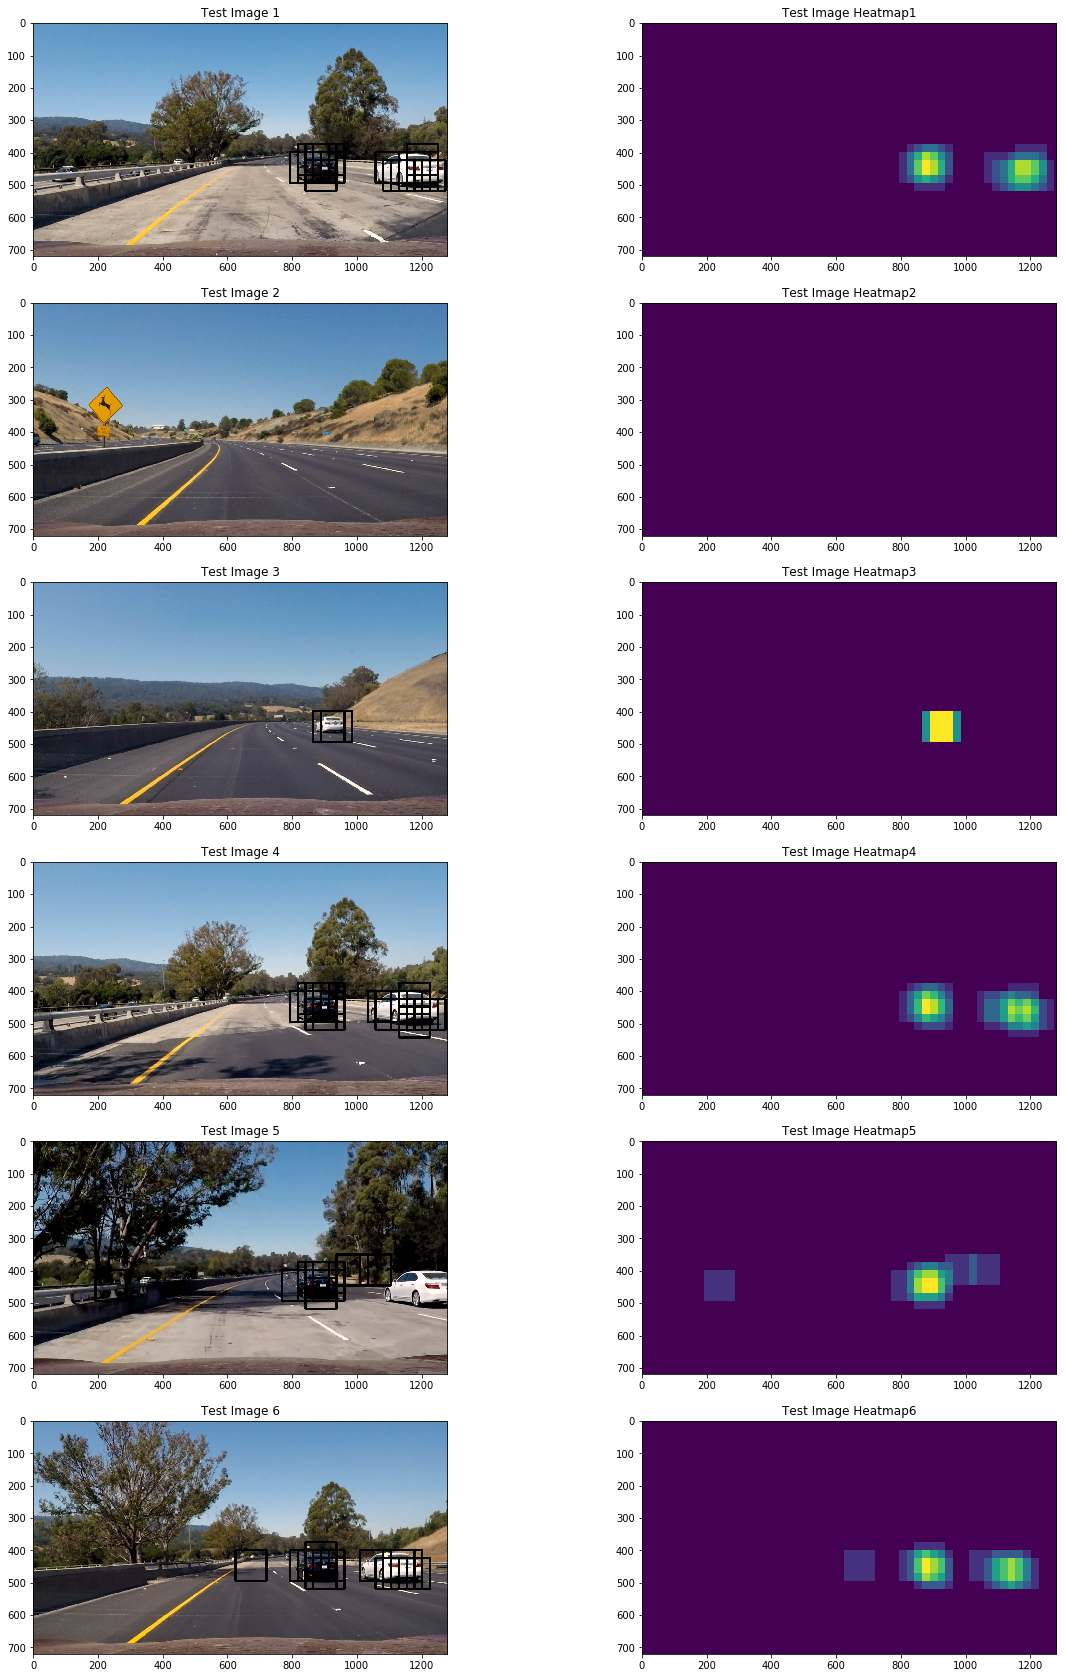

In [90]:
test_images = glob.glob('./test_images/*')
print(len(vehicle_images))

fig = plt.figure(figsize=(20,30))

y_start_stop = [350, 680]


for idx, img in enumerate(test_images): 
    img = mpimg.imread(img)
    heatmap = np.zeros_like(img[:,:,0])
#     convert because jpg and pngs scaled differently and trained on pngs
    img = img.astype(np.float32)/255
    draw_image = np.copy(img)
#     try out different window sizes and overlap
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    print(len(windows))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    add_heat(heatmap, hot_windows)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
    position = idx*2+1
    ax1 = fig.add_subplot(6,2,position)
    ax1.set_title("Test Image " + str(idx+1))
    ax1.imshow(window_img)
    ax1 = fig.add_subplot(6,2,position+1)
    ax1.set_title("Test Image Heatmap" + str(idx+1))
    ax1.imshow(heatmap)
    
        
    

./test_images/test1.jpg
./test_images/test2.jpg
./test_images/test3.jpg
./test_images/test4.jpg
./test_images/test5.jpg
./test_images/test6.jpg


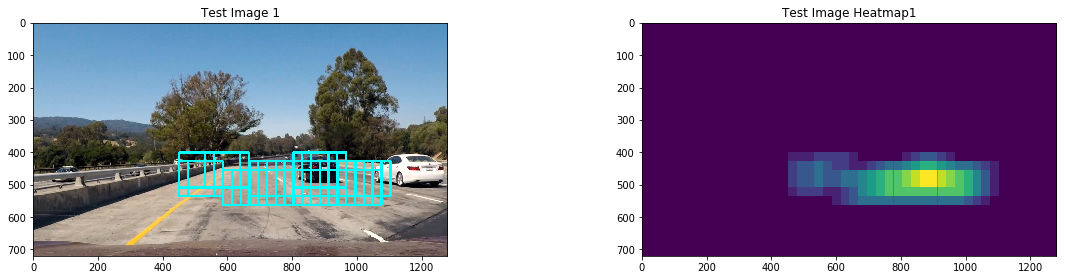

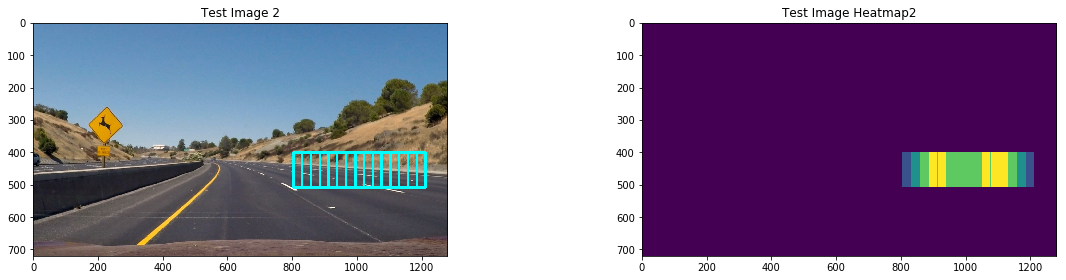

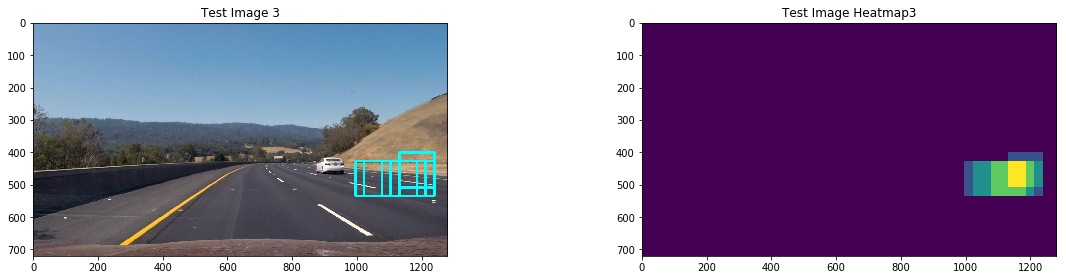

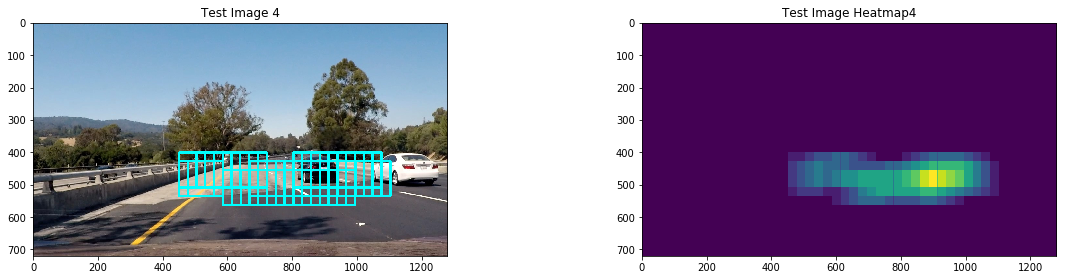

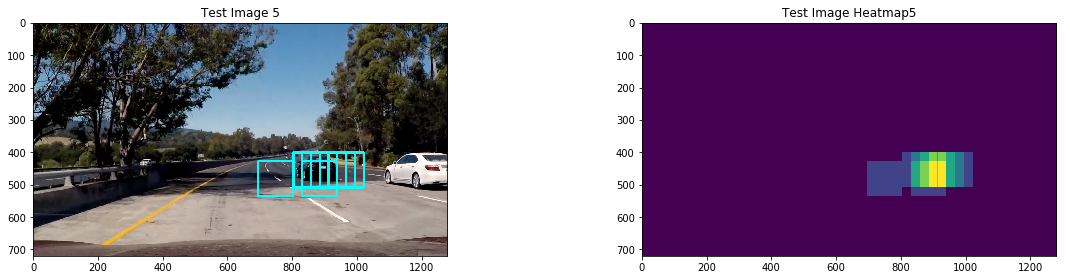

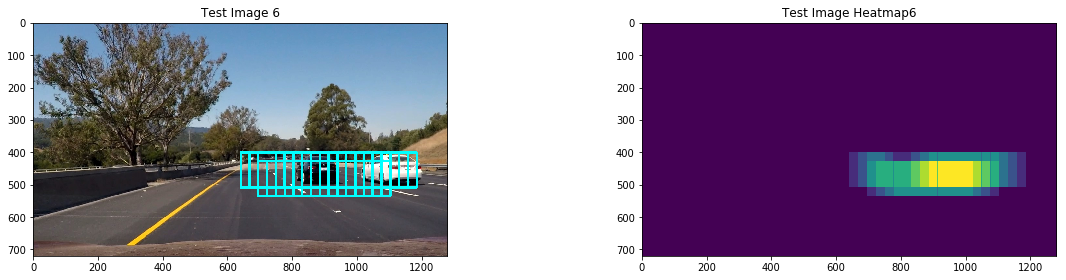

In [91]:
# do HOG transformations for the images first insead of each individual window so pipeline runs faster

# ran faster but was giving way more false positives than above with same params due to hog gradient differences with edges

def find_vehicles(img, idx): 
    y_start_stop = [400, 600]
    ystart = 400
    ystop = 600
    xstart = 450
    # can use scale of image to have same effect of sampling different window sizes
    scale = 1.7

    fig = plt.figure(figsize=(20,30))

    img_boxes = []
    count = 0
    img = mpimg.imread(img)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255


    heatmap = np.zeros_like(img[:,:,0])

    img_cropped = img[ystart:ystop,xstart:,:]
    color_trans_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = color_trans_cropped.shape
        color_trans_cropped = cv2.resize(color_trans_cropped, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))


#     number of hog cells across image is this part
    nxblocks = (color_trans_cropped[:,:,0].shape[1] // pix_per_cell) -1
    nyblocks = (color_trans_cropped[:,:,0].shape[0] // pix_per_cell) -1
    nfeatures_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell ) -1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step


#     compute individual channel HOG features for whole img
    hog_channel_features = []
    for channel in range(color_trans_cropped.shape[2]):
        hog_channel_features.append(get_hog_features(color_trans_cropped[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False))


    for xb in range(nxsteps):
        for yb in range(nysteps):
            collected_features = []
            count +=1
            xpos = xb*cells_per_step
            ypos = yb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            #   take out img section to do spatial and histogram features
            subimg = cv2.resize(img_cropped[ytop:ytop+window, xleft:xleft+window], (64, 64))

            spatial_features = bin_spatial(subimg, size=spatial_size)
            collected_features.append(spatial_features)

            rhist, ghist, bhist, bin_centers, hist_features = color_hist(subimg, nbins=hist_bins)
            #   get hog for this image section
            collected_features.append(hist_features)
            


            hog_features = []
            for h in hog_channel_features:
                hog_features.append(h[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            hog_features = np.concatenate(hog_features)
            collected_features.append(hog_features)

            test_features = X_scaler.transform(np.array(np.concatenate(collected_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
#             if the prediction is there is a vehicle then draw a box and add heat to heatmap
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart), (0,255,255), 6)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left+xstart:xbox_left+win_draw+xstart] +=1

        position = abs(idx*2)+1
        ax1 = fig.add_subplot(6,2,position)
        ax1.set_title("Test Image " + str(idx+1))
        ax1.imshow(draw_img)
        ax1 = fig.add_subplot(6,2,position+1)
        ax1.set_title("Test Image Heatmap" + str(idx+1))
        ax1.imshow(heatmap)

for idx, img in enumerate(test_images):
    print(img)
    find_vehicles(img, idx)

    

8792
821
821
821
821
821
821


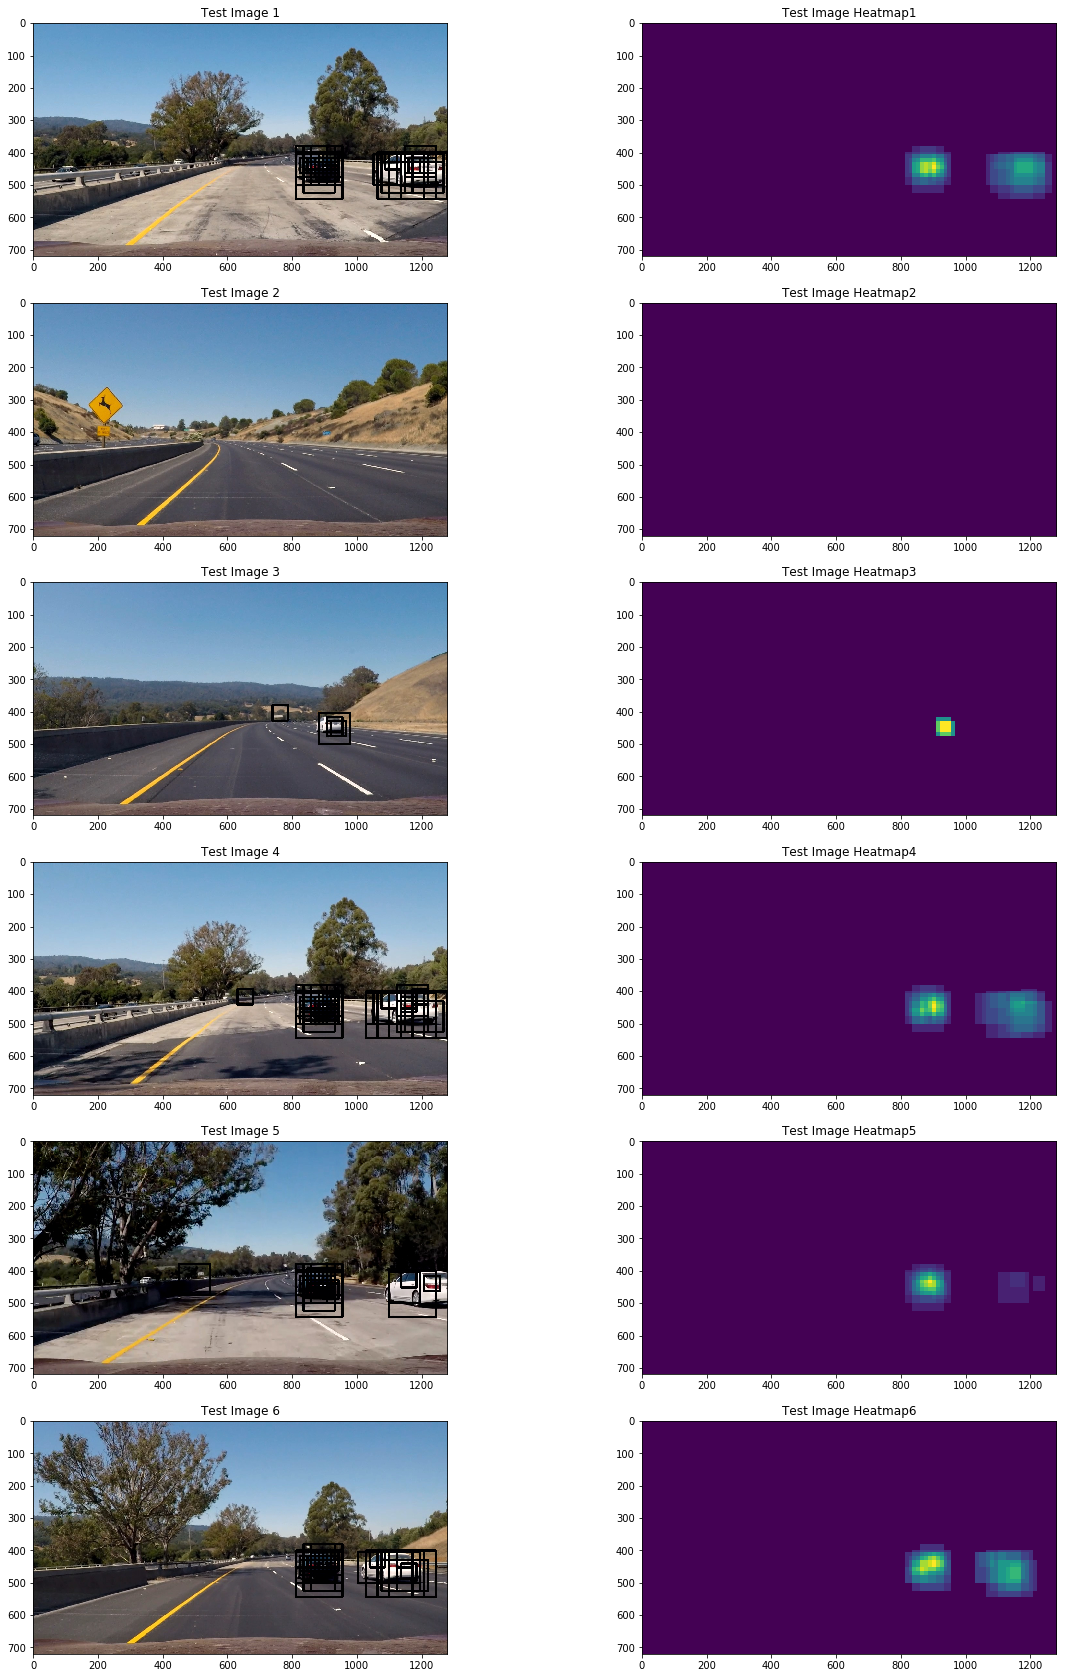

In [150]:
test_images = glob.glob('./test_images/*')
print(len(vehicle_images))

fig = plt.figure(figsize=(20,30))

y_start_stop = [380, 680]
# can ignore things on left for these images -- for real car would need to consider this if in lane other than left
x_start_stop=[450, None]


for idx, img in enumerate(test_images): 
    img = mpimg.imread(img)
    heatmap = np.zeros_like(img[:,:,0])
#     convert because jpg and pngs scaled differently and trained on pngs
    img = img.astype(np.float32)/255
    draw_image = np.copy(img)
    y_start_stop = [380, 680]
#     combine windows of different sizes and overlap to be able to identify both close and far away cars
    windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    #     these cars would have to be close to camera to away so define y_start_stop accordingly
    y_start_stop = [400, 680]
    windows1 = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(144, 144), xy_overlap=(0.75, 0.75))
    windows +=windows1
#     these cars would have to be farther to away so define y_start_stop accordingly
    y_start_stop = [380, 500]
    windows2 = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(48, 48), xy_overlap=(0.75, 0.75))
    windows +=windows2
    print(len(windows))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
#     generate heatmap to visualize where the most likely places with cars are
    add_heat(heatmap, hot_windows)
#     apply threshold to heatmap to try to filter out false positives
    heatmap = apply_threshold(heatmap, 2)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
    position = idx*2+1
    ax1 = fig.add_subplot(6,2,position)
    ax1.set_title("Test Image " + str(idx+1))
    ax1.imshow(window_img)
    ax1 = fig.add_subplot(6,2,position+1)
    ax1.set_title("Test Image Heatmap" + str(idx+1))
    ax1.imshow(heatmap)

In [180]:
# define function for generating thresholded heatmap for images based on experimentation above

def find_cars(img):
    heatmap = np.zeros_like(img[:,:,0])
#     convert because jpg and pngs scaled differently and trained on pngs
    draw_image = np.copy(img)
    y_start_stop = [380, 680]
#     combine windows of different sizes and overlap to be able to identify both close and far away cars
    windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    #     these cars would have to be close to camera to away so define y_start_stop accordingly
    y_start_stop = [400, 680]
    windows1 = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(144, 144), xy_overlap=(0.75, 0.75))
    windows +=windows1
#     these cars would have to be farther to away so define y_start_stop accordingly
    y_start_stop = [380, 500]
    windows2 = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(48, 48), xy_overlap=(0.75, 0.75))
    windows +=windows2

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
#     generate heatmap to visualize where the most likely places with cars are
    add_heat(heatmap, hot_windows)
#     apply threshold to heatmap to try to filter out false positives
    heatmap = apply_threshold(heatmap, 2)
    return heatmap

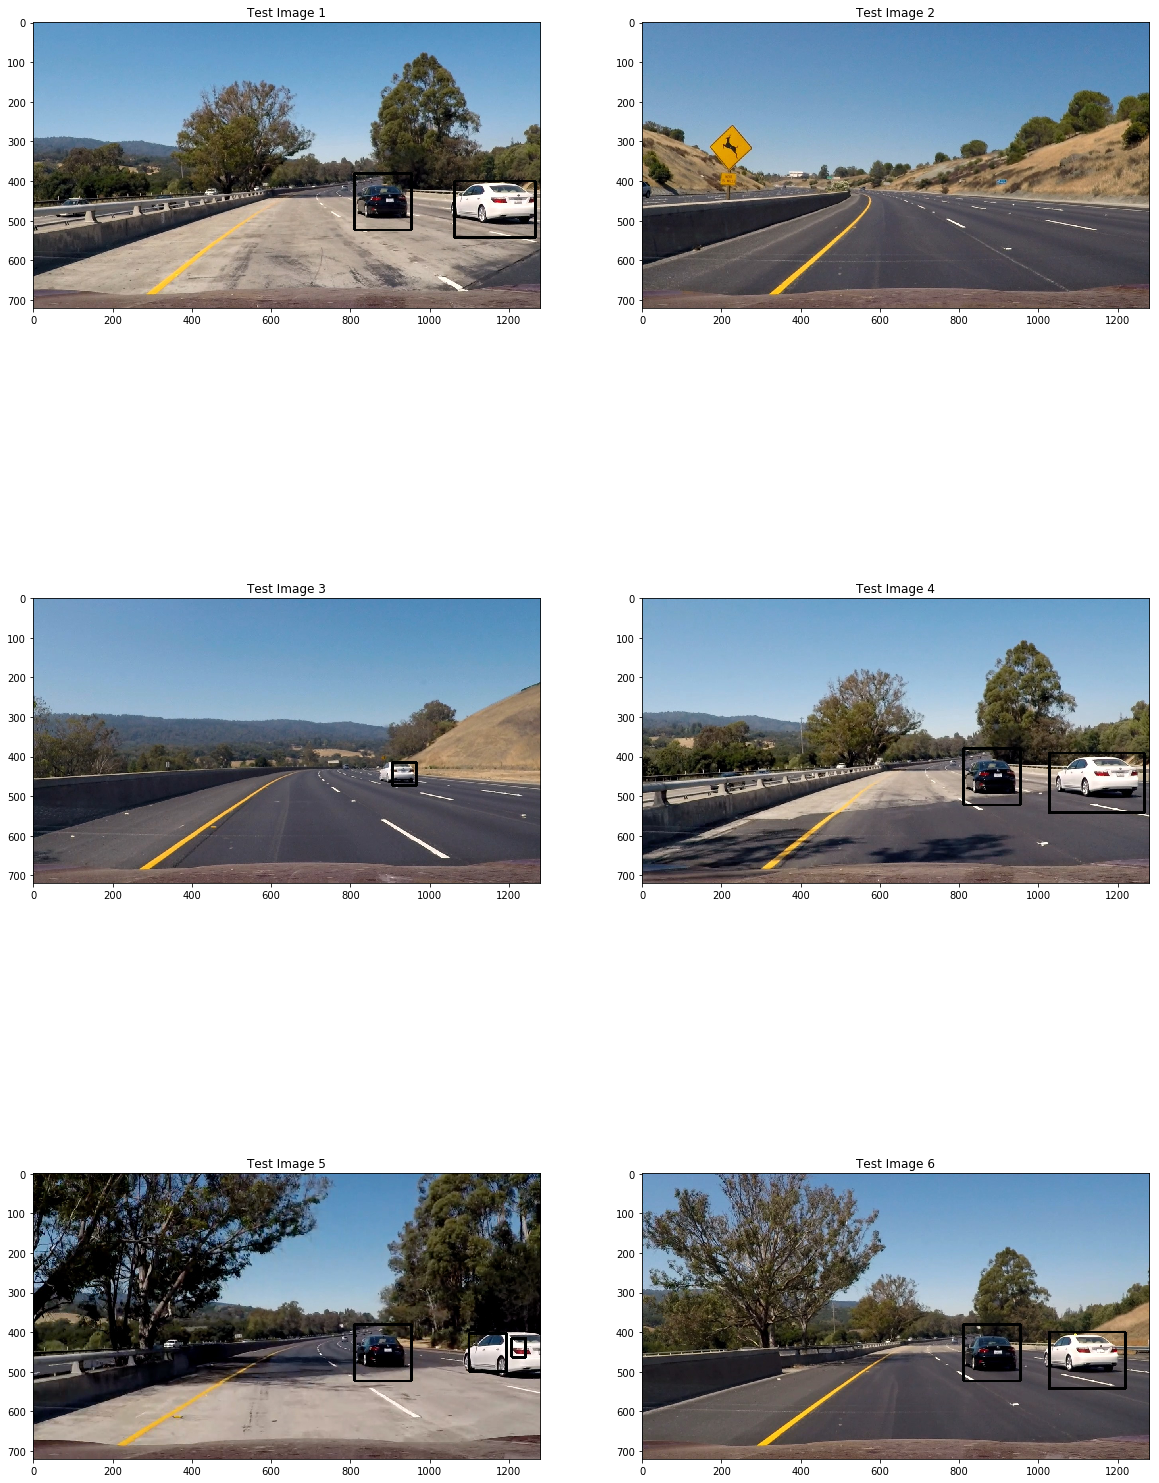

In [191]:
# get labels from thresholded heatmap and apply bounding boxes to vehicles in image
from scipy.ndimage.measurements import label


fig = plt.figure(figsize=(20,30))

for idx, img in enumerate(test_images): 
    img = mpimg.imread(img)
    img = img.astype(np.float32)/255
    heatmap = find_cars(img)
    labels = label(heatmap)
    image_w_bboxes = draw_labeled_bboxes(img, labels)
    ax1 = fig.add_subplot(3,2,idx+1)
    ax1.set_title("Test Image " + str(idx+1))
    ax1.imshow(image_w_bboxes)
    
    

In [200]:
# define function to process images and return the bounding boxes as we did above

def find_img_cars(img):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = find_cars(img)
    labels = label(heatmap)
    image_w_bboxes = draw_labeled_bboxes(draw_img, labels)
    return image_w_bboxes

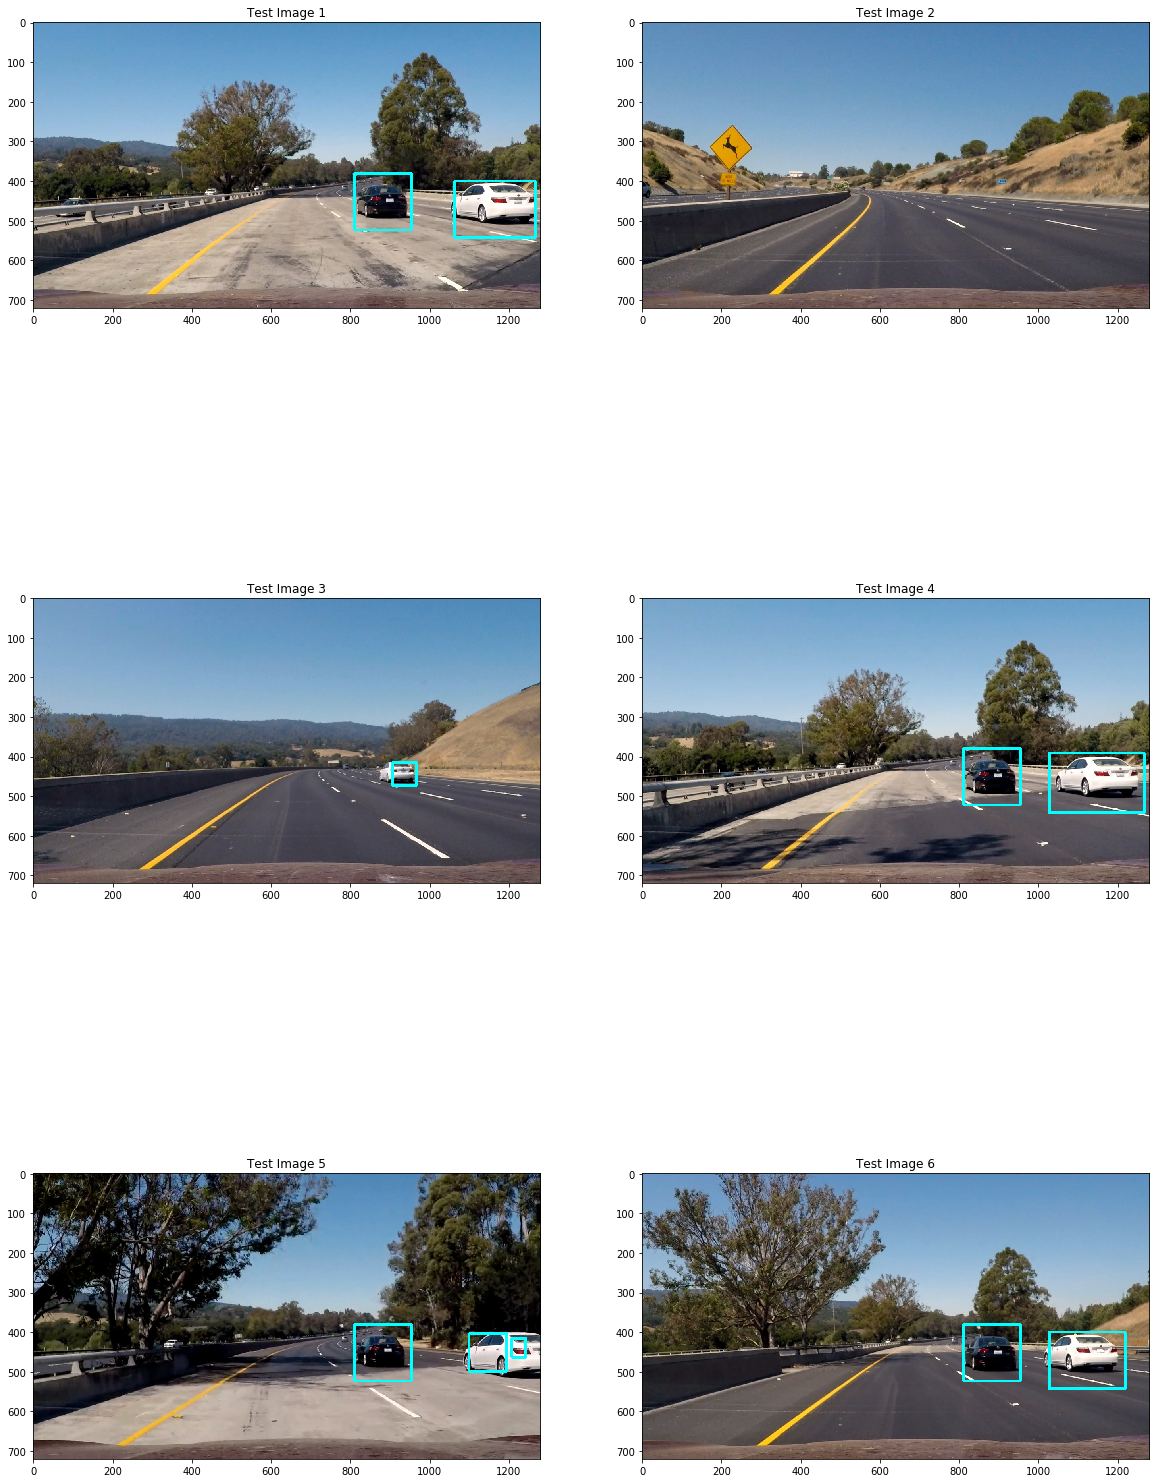

In [201]:
fig = plt.figure(figsize=(20,30))

for idx, img in enumerate(test_images): 
    img = mpimg.imread(img)
    img_cars = find_img_cars(img)
    ax1 = fig.add_subplot(3,2,idx+1)
    ax1.set_title("Test Image " + str(idx+1))
    ax1.imshow(img_cars)

In [202]:
# run on test video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test_video_output.mp4'

clip = VideoFileClip('./test_video.mp4')
testclip = clip.fl_image(find_img_cars)
testclip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:48<00:02,  2.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



In [203]:
HTML("""
<video width="320" height="240" controls>
  <source src="test_video_output.mp4" type="video/mp4">
</video>
""")

In [204]:
vid_output = 'project_video_output.mp4'

vid_clip = VideoFileClip('./project_video.mp4')
testclip = vid_clip.fl_image(find_img_cars)
testclip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [1:00:03<00:02,  2.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [205]:
HTML("""
<video width="320" height="240" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>
""")